In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, uniform, gamma, lognorm
import os
import seaborn as sns
import time
import scipy.io as sio
import scipy

# before starting

In [2]:

class value_efficient_coding_ro():
    def __init__(self, prior='uniform', N_neurons=40, R_t = 250, X_OPT_ALPH=1.0,
                 slope_scale = 4, simpler = False, mu = 0.4, var=0.01, xminmax =[0.2,0.8]):
        # real data prior
        self.offset = 0
        self.juice_magnitudes = np.array(
            [0.2, 0.4, 0.6]) + self.offset
        if prior == 'uniform':
            self.juice_prob = np.array([1/3.0, 1/3.0, 1/3.0])
        else:
            self.juice_prob = np.array([2/15.0, 11/15.0, 2/15.0])
        self.juice_prob /= np.sum(self.juice_prob)

        if simpler: # to boost computation
            self.x = np.linspace(0, 0.8, num=int(1e3))
            self.x_inf = np.linspace(0, 8, num=int(1e4))
        else:
            self.x = np.linspace(0, 0.8, num=int(1e4))
            self.x_inf = np.linspace(0, 8, num=int(1e5))

        self._x_gap = self.x[1] - self.x[0]
        self.x_minmax = [0, 0.8]

        p_thresh = (2 * np.arange(N_neurons) + 1) / N_neurons / 2


        if prior == 'uniform':
            self.juice_prob = np.array([1/3.0, 1/3.0, 1/3.0])
            # self.p_prior = np.zeros( self.x.shape)
            # self.p_prior[2500:7500] = uniform.pdf(self.x[2500:7500]) # np.argmin(np.abs(self.x-0.2)), np.argmin(np.abs(self.x-0.6))
            self.p_prior = uniform.pdf(self.x) # np.argmin(np.abs(self.x-0.2)), np.argmin(np.abs(self.x-0.6))
            # self.p_prior = lognorm.pdf(self.x, s=0.71, scale=np.exp(1.289))
            # self.p_prior_inf = np.zeros( self.x_inf.shape)
            # self.p_prior_inf[2500:7500] = uniform.pdf(self.x_inf[2500:7500]) #np.argmin(np.abs(self.x-0.2)), np.argmin(np.abs(self.x-0.6))
            self.p_prior_inf = uniform.pdf(self.x_inf) # np.argmin(np.abs(self.x-0.2)), np.argmin(np.abs(self.x-0.6))
            # self.p_prior_inf = lognorm.pdf(self.x_inf, s=0.71, scale=np.exp(1.289))

            self.p_prior = self.p_prior / np.sum(self.p_prior * self._x_gap)
            self.p_prior_inf = self.p_prior_inf / \
                np.sum(self.p_prior_inf * self._x_gap)

            # pseudo p-prior to make the sum of the p-prior in the range can be 1
            self.p_prior_pseudo = []
            ppp_cumsum = np.cumsum(self.p_prior_inf * self._x_gap)
            ppp_cumsum /= ppp_cumsum[-1]  # Offset
            self.p_prior_pseudo.append(ppp_cumsum[0])
            for i in range(len(ppp_cumsum) - 1):
                self.p_prior_pseudo.append(
                    (ppp_cumsum[i + 1] - ppp_cumsum[i]) / self._x_gap)
            self.p_prior_pseudo = np.array(self.p_prior_pseudo)
        else:
            self.juice_prob = np.array([2/15.0, 11/15.0, 2/15.0])
            # 평균과 분산 계산
            mu = np.dot(self.juice_prob, [0.2, 0.4, 0.6])
            var = np.dot(self.juice_prob, [(0.2 - mu) ** 2, (0.4 - mu) ** 2, (0.6 - mu) ** 2])

            # 정규분포 근사
            norm_dist = norm(loc=mu, scale=np.sqrt(var))

            self.p_prior= norm_dist.pdf(self.x)
            self.p_prior_inf = norm_dist.pdf(self.x_inf)

            self.p_prior = self.p_prior / np.sum(self.p_prior * self._x_gap)
            self.p_prior_inf = self.p_prior_inf / \
                np.sum(self.p_prior_inf * self._x_gap)

            # pseudo p-prior to make the sum of the p-prior in the range can be 1
            self.p_prior_pseudo = []
            ppp_cumsum = np.cumsum(self.p_prior_inf * self._x_gap)
            ppp_cumsum /= ppp_cumsum[-1]  # Offset
            self.p_prior_pseudo.append(ppp_cumsum[0])
            for i in range(len(ppp_cumsum) - 1):
                self.p_prior_pseudo.append(
                    (ppp_cumsum[i + 1] - ppp_cumsum[i]) / self._x_gap)
            self.p_prior_pseudo = np.array(self.p_prior_pseudo)


        # since we posit a distribution ranged in [0,20] (mostly) we hypothesized that integral from -inf to +inf is same
        # as the integral from 0 to 20 in this toy example. From now on, we just calculated cumulative distribution using
        # self.x, which ranged from 0 to 20.



        # a prototype sigmoidal response curve
        self.h_s = lambda x: 1 / (1 + np.exp(x))

        # number of neurons
        self.N = N_neurons

        # total population response: mean of R spikes
        self.R = R_t

        # p_prior_sum = self.p_prior/np.sum(self.p_prior)
        # self.cum_P = np.cumsum(p_prior_sum)

        # to prevent 0 on denominator in self.g
        p_prior_sum = self.p_prior / np.sum(self.p_prior)
        self.cum_P = np.cumsum(p_prior_sum) # - 1e-3  # for approximation
        self.cum_P /= 1+1e-3

        # p_prior_inf_sum = self.p_prior_inf/np.sum(self.p_prior_inf)
        p_prior_inf_sum = self.p_prior_inf / np.sum(self.p_prior_inf)
        self.cum_P_pseudo = np.cumsum(
            p_prior_inf_sum) # - 1e-5  # for approximation
        self.cum_P_pseudo /= 1+1e-3

        norm_d = self.p_prior / (1-self.cum_P)**(1-X_OPT_ALPH)
        NRMLZR = np.sum(norm_d * self._x_gap)
        norm_d = norm_d / NRMLZR

        cum_norm_D = np.cumsum(self.N * norm_d * self._x_gap)
        cum_norm_Dp = np.cumsum(self.N * norm_d * self._x_gap)/cum_norm_D[-1]

        thresh_ = np.interp(p_thresh, cum_norm_Dp, self.x)
        quant_ = np.interp(thresh_, self.x, cum_norm_Dp)


        # norm_g = self.p_prior_inf**(1-XX2) * self.R / ((self.N) * (1 - self.cum_P_pseudo)**XX2)
        norm_g = 1 / ((1 - self.cum_P)**X_OPT_ALPH)
        # norm_g /= NRMLZR
        norm_g /= self.N
        norm_g *= self.R

        norm_d_pseudo = self.p_prior_pseudo / \
            (1-self.cum_P_pseudo)**(1-X_OPT_ALPH)
        NRMLZR_pseudo = np.sum(norm_d_pseudo * self._x_gap)
        norm_d_pseudo = norm_d_pseudo / NRMLZR_pseudo

        cum_norm_D_pseudo = np.cumsum(self.N * norm_d_pseudo * self._x_gap)
        cum_norm_D_pseudop = np.cumsum(self.N * norm_d_pseudo * self._x_gap)/cum_norm_D_pseudo[-1]

        thresh_pseudo_ = np.interp(p_thresh, cum_norm_D_pseudop, self.x_inf)
        quant_pseudo_ = np.interp(thresh_pseudo_, self.x_inf, cum_norm_D_pseudop)

        norm_g_pseudo = 1 / \
            ((1 - self.cum_P_pseudo)**X_OPT_ALPH)
        norm_g_pseudo /= self.N
        norm_g_pseudo *= self.R

        # find each neuron's location
        # preferred response of each neuron. It is x=0 in the prototype sigmoid function (where y=0.5)
        self.sn = thresh_
        self.sn_pseudo = thresh_pseudo_
        self.gsn = []
        self.gsn_pseudo = []

        # each neurons response function
        self.neurons_ = []  # self.N number of neurons
        self.neurons_pseudo_ = []  # self.N number of neurons

        for i in range(N_neurons):
            g_sn = norm_g[np.argmin(np.abs(self.x - self.sn[i]))]

            a = slope_scale * quant_[i]
            b = slope_scale * (1 - quant_[i])
            self.neurons_.append(g_sn * scipy.special.betainc(a, b, cum_norm_Dp))
            self.gsn.append(g_sn)

            g_sn = norm_g_pseudo[np.argmin(np.abs(self.x_inf - self.sn_pseudo[i]))]

            a = slope_scale * quant_pseudo_[i]
            b = slope_scale * (1 - quant_pseudo_[i])
            self.neurons_pseudo_.append(g_sn * scipy.special.betainc(a, b, cum_norm_D_pseudop))
            self.gsn_pseudo.append(g_sn)


        # normalize afterward
        NRMLZR_G = self.R/np.sum(np.array(self.neurons_)
                                 * self.p_prior * self._x_gap)
        # neurons_arr=np.array(self.neurons_)*NRMLZR_G
        for i in range(len(self.neurons_)):
            self.neurons_[i] *= NRMLZR_G
            self.gsn[i] *= NRMLZR_G

        # normalize afterward
        NRMLZR_G_pseudo = self.R / \
            np.sum(np.array(self.neurons_pseudo_) *
                   self.p_prior_pseudo * self._x_gap)
        # neurons_arr=np.array(self.neurons_)*NRMLZR_G
        for i in range(len(self.neurons_pseudo_)):
            self.neurons_pseudo_[i] *= NRMLZR_G_pseudo
            self.gsn_pseudo[i] *= NRMLZR_G_pseudo

        self.d_x = norm_d
        self.d_x_pseudo = norm_d_pseudo
        self.g_x = norm_g * NRMLZR_G
        self.g_x_pseudo = norm_g_pseudo * NRMLZR_G_pseudo

    def plot_neurons(self, name='gamma'):
        # plot neurons response functions
        colors = np.linspace(0, 0.7, self.N)
        plt.figure()
        ymax = []
        for i in range(self.N):
            plt.plot(self.x, self.neurons_[i], color=str(colors[i]))
            ymax.append(self.neurons_[i][1499])
        # plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))
        plt.title('Response functions of {0} neurons'.format(self.N))
        if not os.path.exists('./' + name + '/'):
            os.makedirs('./' + name + '/')
        plt.savefig('./' + name + '/' + 'Response functions of {0} neurons 300.png'.format(self.N))
        plt.xlim([0, 0.8])
        plt.ylim([0, 100])
        plt.savefig('./' + name + '/' + 'Response functions of {0} neurons.png'.format(self.N))

    def plot_others(self, name='gamma'):

        plt.figure()
        plt.title('Prior distribution')
        plt.plot(self.x, self.p_prior)
        if not os.path.exists('./' + name + '/'):
            os.makedirs('./' + name + '/')
        plt.xlim([0, 0.8])
        plt.ylim([0, 2])
        plt.savefig('./' + name + '/' + 'Prior distribution 300.png')
        plt.figure()
        plt.title('Density function')
        plt.plot(self.x, self.d_x)
        plt.xlim([0, 0.8])
        plt.ylim([0, 2])
        plt.savefig('./' + name + '/' + 'Density function 300.png')
        plt.figure()
        plt.title('Gain function')
        plt.plot(self.x, self.g_x)
        plt.xlim([0, 0.8])
        plt.ylim([0, 100])
        plt.savefig('./' + name + '/' + 'Gain function 300.png')

        plt.clf()

        # plt.figure()
        # plt.title('Prior distribution')
        # plt.plot(self.x[:ind30], self.p_prior[:ind30])
        # if not os.path.exists('./' + name + '/'):
        #     os.makedirs('./' + name + '/')
        # plt.savefig('./' + name + '/' + 'Prior distribution.png')
        # plt.figure()
        # plt.title('Density function')
        # plt.plot(self.x[:ind30], self.d_x[:ind30])
        # plt.savefig('./' + name + '/' + 'Density function.png')
        # plt.figure()
        # plt.title('Gain function')
        # plt.plot(self.x[:ind30], self.g_x[:ind30])
        # plt.savefig('./' + name + '/' + 'Gain function.png')


In [3]:
import numpy as np

# Load CSV file using NumPy's genfromtxt() function
data = np.genfromtxt('rothenhoefer.csv', delimiter=',')

# Print the dataㅠ
print(data)


[[3.47826087 5.69454545]
 [5.04347826 5.06181818]
 [5.08695652 5.14909091]
 [5.26086957 3.86181818]
 [4.73913043 3.64363636]
 [4.60869565 2.44363636]
 [3.58695652 1.65818182]
 [3.47826087 2.46545455]
 [3.73913043 3.33818182]
 [4.2173913  4.21090909]
 [3.80434783 4.82181818]
 [3.36956522 4.82181818]
 [3.23913043 4.03636364]
 [3.02173913 3.64363636]
 [3.13043478 3.51272727]
 [2.93478261 3.29454545]
 [2.95652174 3.07636364]
 [2.80434783 2.92363636]
 [2.67391304 3.75272727]
 [2.67391304 3.46909091]
 [2.80434783 4.03636364]
 [2.2826087  3.51272727]
 [2.06521739 2.74909091]
 [2.56521739 2.50909091]
 [2.02173913 2.18181818]
 [1.7173913  0.96      ]
 [0.67391304 1.22181818]
 [0.2173913  0.52363636]
 [1.2826087  2.05090909]
 [1.7173913  2.26909091]
 [1.52173913 2.4       ]
 [1.65217391 2.53090909]
 [1.39130435 2.88      ]
 [1.65217391 3.03272727]
 [1.36956522 3.20727273]
 [1.86956522 3.62181818]
 [2.26086957 4.51636364]
 [2.26086957 4.73454545]
 [2.43478261 4.75636364]
 [1.89130435 5.12727273]]

In [4]:
from scipy.optimize import curve_fit
def estimate_slope(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    def linear_model(x, a):
        return a * x

    popt, _ = curve_fit(linear_model,x, y)

    return popt


In [5]:
# function that estimates not only slope but also intercept
def estimate_slope_intercept(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x, y)
    return model.coef_[0][0], model.intercept_[0]

# estimate slope and intercept of y=data[:,1] and x=data[:,0]
slope, intercept = estimate_slope_intercept(data[:,0], data[:,1])
# calculate y = slope * data[:,0] + intercept
y_data = slope * data[:,0] + intercept

In [6]:
# function that estimates not only slope but also intercept
def estimate_slope_fitwith_intercept(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x, y)
    return model.coef_[0][0]


In [7]:
# write wrapper_func_alpha
def wrapper_func_alpha(args):
    N_neurons = 40
    alpha = args[0]
    R_t = args[1]
    slope_scale = args[2]
    spon_act = args[3]
    # cal slopes using spon_act

    ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
    ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        norm_res.append(estimate_slope(ec_norm.x, ec_norm.neurons_[i]))
        unfm_res.append(estimate_slope(ec_unfm.x, ec_unfm.neurons_[i]))

    norm_res = np.array(norm_res)
    unfm_res = np.array(unfm_res)

    return norm_res, unfm_res

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, uniform, gamma, lognorm
import os
import seaborn as sns
import time
import scipy.io as sio
import scipy

In [9]:
# wrapper_func_alpha_poisson but with one more argument that number of samples
def wrapper_func_alpha_poisson_samples(args):
    N_neurons = 40
    alpha = args[0]
    # others uses res.x
    R_t = args[1]
    slope_scale = args[2]
    spon_act = args[3]
    samples = int(args[4])

    # cal slopes using spon_act

    ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
    ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        # poisson sapmling using norm_neg, norm_0, norm_pos but 100 samples
        norm_neg = np.random.poisson(ec_norm.neurons_[i][2500], samples)
        norm_0 = np.random.poisson(ec_norm.neurons_[i][5000], samples)
        norm_pos = np.random.poisson(ec_norm.neurons_[i][7500], samples)

        #take mean of norm_neg, norm_0, norm_pos
        norm_neg = np.mean(norm_neg)
        norm_0 = np.mean(norm_0)
        norm_pos = np.mean(norm_pos)

        norm_neg -= spon_act
        norm_0 -= spon_act
        norm_pos-= spon_act
        norm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [norm_neg, norm_0, norm_pos]))

        unfm_neg = np.random.poisson(ec_unfm.neurons_[i][2500], samples)
        unfm_0 = np.random.poisson(ec_unfm.neurons_[i][5000], samples)
        unfm_pos = np.random.poisson(ec_unfm.neurons_[i][7500], samples)

        #take mean of unfm_neg, unfm_0, unfm_pos
        unfm_neg = np.mean(unfm_neg)
        unfm_0 = np.mean(unfm_0)
        unfm_pos = np.mean(unfm_pos)

        unfm_neg -= spon_act
        unfm_0 -= spon_act
        unfm_pos -= spon_act

        unfm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [unfm_neg, unfm_0, unfm_pos]))

    return norm_res, unfm_res

alpha = 0.5
diff_list = []
for seed in range(100):
    np.random.seed(seed)

    # call wrapper_func_alpha with alpha
    norm_res, unfm_res = wrapper_func_alpha_poisson_samples([alpha, res.x[1], res.x[2], res.x[3], 10000])

    # print alpha in a fancy way
    print('seed: {}'.format(seed))


    # calculate slope of two line plots
    slope_fitting = np.polyfit(unfm_res, norm_res, 1)[0]
    slope_data = np.polyfit(data[:,0], data[:,1], 1)[0]

    #diff of slopes
    diff = slope_fitting - slope_data

    # append diff to diff_list
    diff_list.append(diff)



# find argmin_seed of diff_list
argmin_seed = np.argmin(diff_list)
print('argmin_seed: {}'.format(argmin_seed))



In [10]:

N_neurons = 40
alpha = 1
# others uses res.x
R_t = 150
slope_scale = 0.3
spon_act = 5

# cal slopes using spon_act

ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)



norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

# figure plans 1

figure that with the discrete overlay

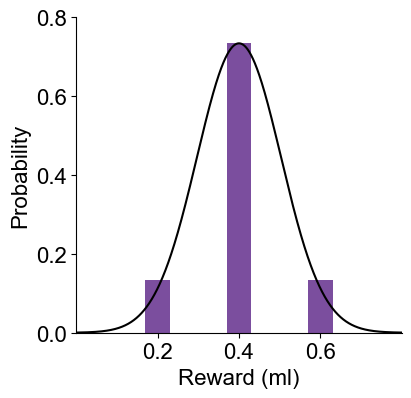

In [11]:
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)

# set the maximum of ec_norm.p_prior as 11/15
ec_norm.p_prior = ec_norm.p_prior/np.max(ec_norm.p_prior)*11/15
# ec_norm.p_prior = ec_norm.p_prior/15*11

ax.plot(ec_norm.x, ec_norm.p_prior, color=[0,0,0])
# barplot of [0.2, 0.4, 0.6] and [2/15. 11/15, 2/15]
ax.bar([0.2, 0.4, 0.6], [2/15, 11/15, 2/15], width=0.06, color='#7b4e9e')

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Probability')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim([0, 0.8])
plt.ylim([0, 0.8])
ax.set_xticks([.2, .4, .6])
ax.set_yticks([0,.2,.4,.6,.8])
fig.set_figwidth(4.2)
fig.set_figheight(4.1)
plt.show()

fig.savefig('./figures_rothenhoefer/'+'normal_distribution.png', bbox_inches="tight")

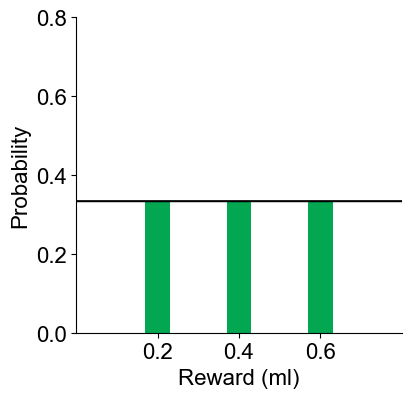

In [12]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)

ec_unfm.p_prior = ec_unfm.p_prior/np.max(ec_unfm.p_prior)*5/15
ax.plot(ec_unfm.x, ec_unfm.p_prior, color=[0,0,0])
ax.bar([0.2, 0.4, 0.6], [5/15, 5/15, 5/15], width=0.06, color='#03a651')

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Probability')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim([0, 0.8])
plt.ylim([0, 0.8])
ax.set_xticks([.2, .4, .6])
ax.set_yticks([0,.2,.4,.6,.8])
fig.set_figwidth(4.2)
fig.set_figheight(4.1)
plt.show()

fig.savefig('./figures_rothenhoefer/'+'uniform_distribution.png', bbox_inches="tight")

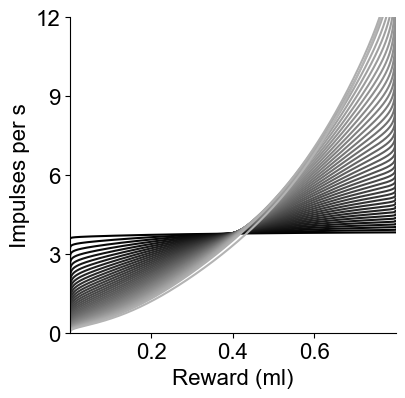

<Figure size 640x480 with 0 Axes>

In [13]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_norm.N)

ymax = []
for i in range(ec_norm.N):
    plt.plot(ec_norm.x, ec_norm.neurons_[i], color=str(colors[i]))
    ymax.append(ec_norm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.show()
plt.savefig('./figures_rothenhoefer/'+'neuron_norm_pop.png', bbox_inches="tight")



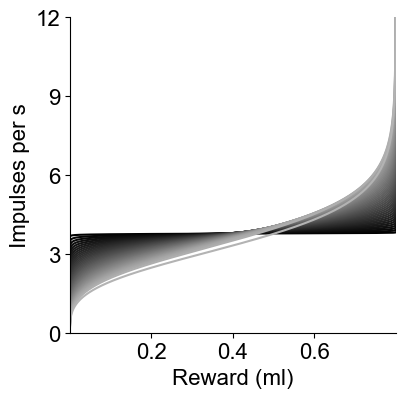

<Figure size 640x480 with 0 Axes>

In [14]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_unfm.N)

ymax = []
for i in range(ec_unfm.N):
    plt.plot(ec_unfm.x, ec_unfm.neurons_[i], color=str(colors[i]))
    ymax.append(ec_unfm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.show()
plt.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop.png', bbox_inches="tight")



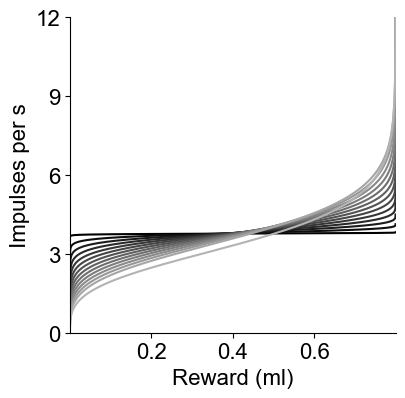

In [15]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_unfm.N)

ymax = []
# subsample for only 1 third of ec_unfm.N
for i in range(ec_unfm.N):
    if i%3 == 0:
        plt.plot(ec_unfm.x, ec_unfm.neurons_[i], color=str(colors[i]))
        ymax.append(ec_unfm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.show()
fig.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop_subsample.png', bbox_inches="tight")



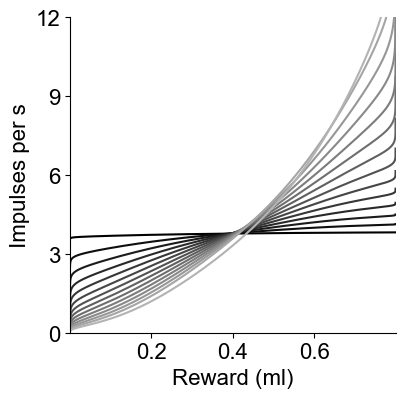

In [16]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_norm.N)

ymax = []
# subsample for only 1 third of ec_unfm.N
for i in range(ec_unfm.N):
    if i%3 == 0:
        plt.plot(ec_norm.x, ec_norm.neurons_[i], color=str(colors[i]))
        ymax.append(ec_norm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.show()
fig.savefig('./figures_rothenhoefer/'+'neuron_norm_pop_subsample.png', bbox_inches="tight")



In [17]:

N_neurons = 40
alpha = 1
# others uses res.x
R_t = 150
slope_scale = 0.3
spon_act = 3.92

# cal slopes using spon_act

ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)



norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

(10000,)


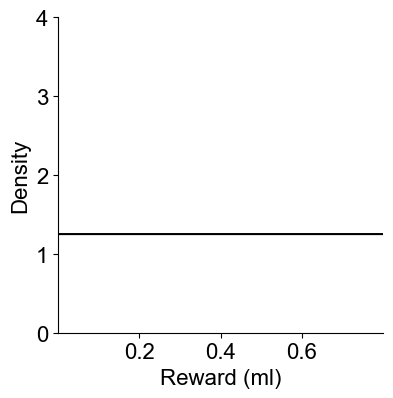

In [18]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

midpoints = []
ymax = []
for i in range(ec_unfm.N):
    ymax.append(ec_unfm.neurons_[i][1499])

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])



# ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.max(), color=str(0.7))

# normalize ec_unfm.d_x so that area under curve is 1
# ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.sum(), color=str(0.7))



ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.sum()/ec_unfm._x_gap, color='k')

plt.ylim([0, 4])
plt.xlim([0, 0.8])
print(ec_norm.d_x.shape)
plt.show()
fig.savefig('./figures_rothenhoefer/'+'uniform_density_only.png', bbox_inches="tight")


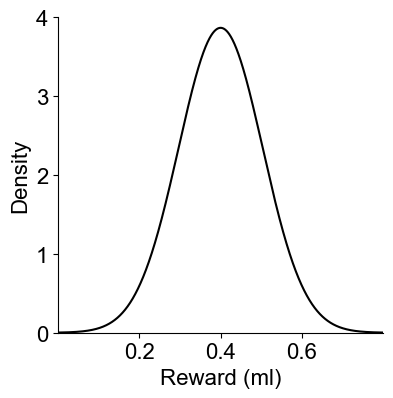

In [19]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)
midpoints=[]
ymax = []
for i in range(ec_norm.N):
    ymax.append(ec_norm.neurons_[i][1499])

    # check if every points in ec_norm.neurons_[i] is smaller than spon_act
    if not np.all(ec_norm.neurons_[i] < spon_act):
        # print(np.argmin(np.abs(ec_norm.neurons_[i] - spon_act)))
        # append midpoints that is ec_unfm.neurons_[i] is closest to spon_act
        midpoints.append(ec_norm.x[np.argmin(np.abs(ec_norm.neurons_[i] - spon_act))])
    else:
        # APPEND nothing to midpoints
        ''


ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Density')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

plt.ylim([0, 4])
plt.xlim([0, 0.8])


# normalize ec_norm.d_x so that area under curve is 1
ax.plot(ec_norm.x, ec_norm.d_x/ec_norm.d_x.sum()/ec_norm._x_gap, color='k')
plt.show()

fig.savefig('./figures_rothenhoefer/'+'normal_density.png', bbox_inches="tight")

%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)
midpoints=[]
ymax = []
for i in range(ec_norm.N):
    ymax.append(ec_norm.neurons_[i][1499])

    # check if every points in ec_norm.neurons_[i] is smaller than spon_act
    if not np.all(ec_norm.neurons_[i] < spon_act):
        # print(np.argmin(np.abs(ec_norm.neurons_[i] - spon_act)))
        # append midpoints that is ec_unfm.neurons_[i] is closest to spon_act
        midpoints.append(ec_norm.x[np.argmin(np.abs(ec_norm.neurons_[i] - spon_act))])
    else:
        # APPEND nothing to midpoints
        ''
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))
ax.vlines(midpoints, 0, 0.2*np.ones(len(midpoints)),colors='k')


kde = gaussian_kde(midpoints,bw_method=0.5)
x = np.linspace(0, 0.8, 1000)
y = kde(x)
# plot the density
ax.plot(x, y, color='k')


ax.set_xlabel('Reward (ml)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,1,2,3,4,5])

plt.xlim([0, 0.8])
plt.ylim([0, 4])


fig.savefig('normal_density.png', bbox_inches="tight")

ax.plot(ec_norm.x, ec_norm.d_x, color=str(0.7))
fig.savefig('normal_density_midpoints.png', bbox_inches="tight")

# figure plans 2

In [20]:
# load csv file that named 'data_dots.csv'
import pandas as pd
df = pd.read_csv('data_dots.csv')



In [21]:
# change data frame to numpy
green_line = df['Unnamed: 1'][1:4].to_numpy()
green_line = [float(datum) for datum in green_line]
green_dots = df['Unnamed: 5'][1:4].to_numpy()
green_dots = [float(datum) for datum in green_dots]
green_errs = df['Unnamed: 9'][1:7].to_numpy()
green_errs = [float(datum) for datum in green_errs]
green_errs = [green_errs[2*i]-green_errs[2*i+1] for i in range(3)]


purple_line = df['Unnamed: 3'][1:4].to_numpy()
purple_line = [float(datum) for datum in purple_line]
purple_dots = df['Unnamed: 7'][1:4].to_numpy()
purple_dots = [float(datum) for datum in purple_dots]
purple_errs = df['Unnamed: 11'][1:7].to_numpy()
purple_errs = [float(datum) for datum in purple_errs]
purple_errs = [purple_errs[2*i]-purple_errs[2*i+1] for i in range(3)]



In [22]:
# print green line and purple line
print(green_line)
print(purple_line)

[-1.6882453151618408, -0.27768313458262384, 1.10221465076661]
[-2.8994889267461676, -0.17035775127768282, 2.558773424190801]


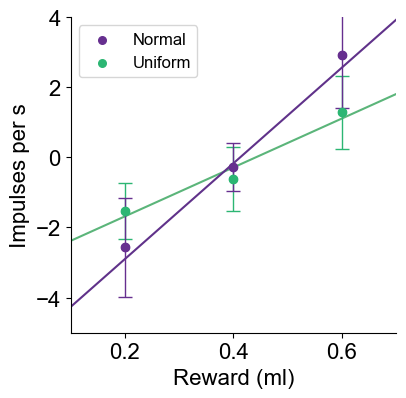

In [23]:
%matplotlib inline
ind = 25
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


# estimate slope and intercept using estimate_slope_intercept function
slope1, intercept1 = estimate_slope_intercept([0.2,0.4,0.6],green_line)
slope2, intercept2 = estimate_slope_intercept([0.2,0.4,0.6],purple_line)

# plot lines
x = np.linspace(0,1,1000)
ax.plot(x, slope1*x+intercept1, color='#5BB57A')
ax.plot(x, slope2*x+intercept2, color='#60328A')



ax.scatter([0.2,0.4,0.6], purple_dots, color='#662f8f', label='Normal', s = 30)
ax.scatter([0.2,0.4,0.6], green_dots, color='#2cb673', label='Uniform',s = 30)

# plot error bar around green dots
ax.errorbar([0.2,0.4,0.6], green_dots, yerr=green_errs, fmt='o', color='#2cb673', capsize=5, elinewidth=1)
ax.errorbar([0.2,0.4,0.6], purple_dots, yerr=purple_errs, fmt='o', color='#662f8f', capsize=5, elinewidth=1)


ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')
ax.set_xticks([.2, .4, .6])
# ax.set_yticks([-5,-4,-3,-2,-1,0,1,2,3,4])

plt.xlim([0.1, 0.7])
plt.ylim([-5, 4])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

#legend but that is smaller
ax.legend(fontsize=12)
plt.show()

fig.savefig('./figures_rothenhoefer/'+'comparing.png', bbox_inches="tight")



In [24]:

N_neurons = 40
alpha = 0.5
# others uses res.x
R_t = 150
slope_scale = 0.3
spon_act = 3.92

# cal slopes using spon_act

ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)



norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

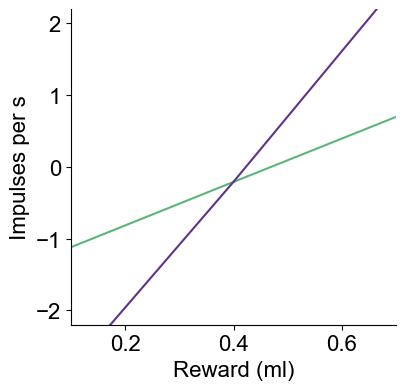

In [25]:
%matplotlib inline
ind = 25
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)

# lower part
slope1 = (unfm_res[ind][1] - unfm_res[ind][0])/0.2
slope2 = (norm_res[ind][1] - norm_res[ind][0])/0.2
x_lower = np.linspace(-0.2, 0.4, 10)
ax.plot(x_lower, slope1*(x_lower - 0.4) + unfm_res[ind][1],color='#5BB57A', label='uniform')
ax.plot(x_lower, slope2*(x_lower - 0.4) + norm_res[ind][1],color='#60328A', label='normal')


# higher part
slope1 = (unfm_res[ind][2] - unfm_res[ind][1])/0.2
slope2 = (norm_res[ind][2] - norm_res[ind][1])/0.2
x_higher = np.linspace(0.4, 1, 10)
ax.plot(x_higher, slope1*(x_higher - 0.4) + unfm_res[ind][1],color='#5BB57A')
ax.plot(x_higher, slope2*(x_higher - 0.4) + norm_res[ind][1],color='#60328A')

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')
ax.set_xticks([.2, .4, .6])
# ax.set_yticks([-5,-4,-3,-2,-1,0,1,2,3,4])

plt.xlim([0.1, 0.7])
plt.ylim([-2.2, 2.2])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

#legend but that is smaller
# ax.legend(fontsize=12)
plt.show()

fig.savefig('./figures_rothenhoefer/'+'comparing_our.png', bbox_inches="tight")



# fitting

In [26]:
data = np.genfromtxt('rothenhoefer.csv', delimiter=',')


from scipy.optimize import curve_fit
def estimate_slope(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1)
    y = y.reshape(-1)
    def linear_model(xx, a):
        return a * xx
    popt, _ = curve_fit(linear_model,x, y)
    return popt

# estimate_slope_intercept to get slope and intercept from data
slope = estimate_slope(data[:,0], data[:,1])

In [27]:
def fitting_line(params):
    N_neurons = 40
    alpha_norm = params[0]
    alpha_unfm = params[1]
    # others uses res.x
    R_t = 150
    slope_scale_norm = params[2]
    slope_scale_unfm = params[3]
    spon_act = 5
    samples = 10000

    # if any of params is equal or smaller than 0, return a large number
    if alpha_norm <= 0 or alpha_unfm <= 0 or slope_scale_norm <= 0 or slope_scale_unfm <= 0:
        return 1e5

    # if any of alpha is larger than 1, return a large number
    if alpha_norm > 1 or alpha_unfm > 1:
        return 1e5

    print(slope)


    # cal slopes using spon_act

    ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
    ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        # poisson sapmling using norm_neg, norm_0, norm_pos but 100 samples
        norm_neg = np.random.poisson(ec_norm.neurons_[i][2500], samples)
        norm_0 = np.random.poisson(ec_norm.neurons_[i][5000], samples)
        norm_pos = np.random.poisson(ec_norm.neurons_[i][7500], samples)

        #take mean of norm_neg, norm_0, norm_pos
        norm_neg = np.mean(norm_neg)
        norm_0 = np.mean(norm_0)
        norm_pos = np.mean(norm_pos)

        norm_neg -= spon_act
        norm_0 -= spon_act
        norm_pos-= spon_act
        norm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [norm_neg, norm_0, norm_pos]))

        unfm_neg = np.random.poisson(ec_unfm.neurons_[i][2500], samples)
        unfm_0 = np.random.poisson(ec_unfm.neurons_[i][5000], samples)
        unfm_pos = np.random.poisson(ec_unfm.neurons_[i][7500], samples)

        #take mean of unfm_neg, unfm_0, unfm_pos
        unfm_neg = np.mean(unfm_neg)
        unfm_0 = np.mean(unfm_0)
        unfm_pos = np.mean(unfm_pos)

        unfm_neg -= spon_act
        unfm_0 -= spon_act
        unfm_pos -= spon_act

        unfm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [unfm_neg, unfm_0, unfm_pos]))

    if np.any(np.array(norm_res)<0) or np.any(np.array(unfm_res)<0):
        print(norm_res)
        return 1e5

    # caculate distance of unfm_res and norm_res from the line y=slope*x+intercept
    dist = np.abs(np.array(norm_res) - slope*np.array(unfm_res))

    # sum of squared error
    dist = np.sum(dist**2)


    # print what will be returned
    print(dist)

    # get difference between data[:,0] and unfm_res, data[:,1] and norm_res
    # return sum of squared difference
    return dist

# set seed paramters that linspaced between 0 and 1, 0 and 10
params_0 = np.linspace(0.01,1,3)
params_1 = np.linspace(0.01,1,3)
params_2 = np.linspace(0.01,10,3)
params_3 = np.linspace(0.01,10,3)

# make paramters using meshgrid
param = np.array(np.meshgrid(params_0, params_1, params_2, params_3)).T.reshape(-1,4)



In [28]:
# off warning
import warnings
warnings.filterwarnings('ignore')


# scipy.optimize.minimize to minimize fitting function
import pickle as pkl
os.makedirs('res_fit_to_empirical_rothenhoefer_line_alpha_fit', exist_ok=True)


from scipy.optimize import minimize
# use param
# for but every 10th number in range of len(param)
now = True
if now:
    for i in range(len(param)):
        # do the followings only if there is no file that need to be saved
        if os.path.isfile('./res_fit_to_empirical_rothenhoefer_line_alpha_fit/'+'fitting_'+str(i)+'.pkl'):
            continue

        # print param with its name in a line
        print('param_'+str(i)+':', param[i].tolist())

        # line that separates
        print('------------------------------------')

        res = minimize(fitting_line, param[i].tolist(), method='Powell', options={'disp': True})
        # res = minimize(fitting, [0.5,0.5,0.5,0.5], method='Nelder-Mead', options={'disp': True})

        # save res to res_fit_to_empirical_rothenhoefer using pickle
        with open('./res_fit_to_empirical_rothenhoefer_line_alpha_fit/'+'fitting_'+str(i)+'.pkl', 'wb') as f:
            pkl.dump(res, f)



In [29]:
data = np.genfromtxt('rothenhoefer.csv', delimiter=',')

# after fitting, not arbitrary

## all at once

In [31]:
# load all files in res_fit_to_empirical_rothenhoefer
files = os.listdir('./res_fit_to_empirical_rothenhoefer_line_alpha_fit')
files = [f for f in files if f.endswith('.pkl')]
files.sort()

# make empty list
res = []
# for every file in files
for f in files:
    # open file using pickle
    with open('./res_fit_to_empirical_rothenhoefer_line_alpha_fit/'+f, 'rb') as f:
        res.append(pkl.load(f))


# ...and sorting in ascending order of fun
res_sorted = sorted(res, key=lambda x: x.fun)


# find that has lowest fun
res = res[np.argmin([r.fun for r in res])]
# print res
print(res)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.9040290260131905
       x: [ 1.036e-01  3.013e-01  4.311e-01  1.471e+00]
     nit: 10
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
           [ 3.948e-02 -1.509e-02 -2.291e-01 -9.408e-01]]
    nfev: 864


In [33]:
# ec_norm and ec_unfm with the fitted parameters
params = res.x

N_neurons = 40
alpha_norm = params[0]
alpha_unfm =params[1]
# others uses res.x
R_t = 150
slope_scale_norm = params[2]
slope_scale_unfm = params[3]
spon_act = 5
samples = 10000

# cal slopes using spon_act

ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)


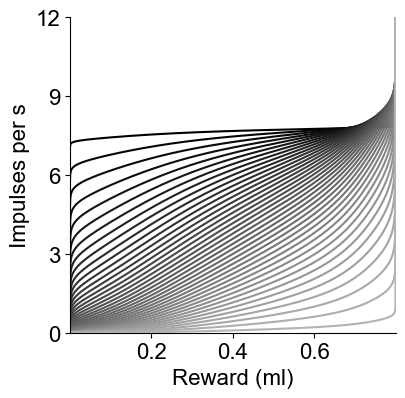

<Figure size 640x480 with 0 Axes>

In [34]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_norm.N)

ymax = []
for i in range(ec_norm.N):
    plt.plot(ec_norm.x, ec_norm.neurons_[i], color=str(colors[i]))
    ymax.append(ec_norm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.show()
plt.savefig('./figures_rothenhoefer/'+'neuron_norm_pop.png', bbox_inches="tight")



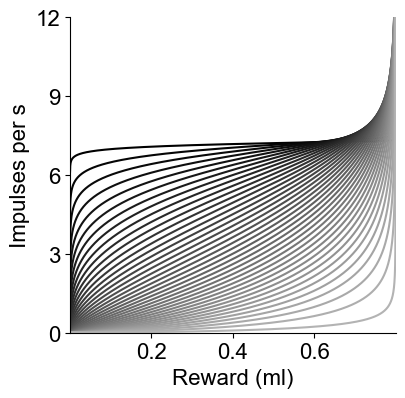

In [35]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_unfm.N)

ymax = []
for i in range(ec_unfm.N):
    plt.plot(ec_unfm.x, ec_unfm.neurons_[i], color=str(colors[i]))
    ymax.append(ec_unfm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop.png', bbox_inches="tight")



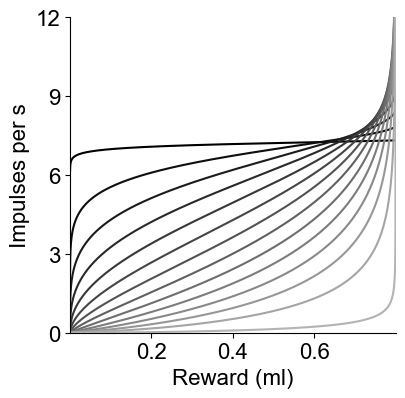

In [36]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_unfm.N)

ymax = []
# subsample for only 1 third of ec_unfm.N
for i in range(ec_unfm.N):
    if i%3 == 0:
        plt.plot(ec_unfm.x, ec_unfm.neurons_[i], color=str(colors[i]))
        ymax.append(ec_unfm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.show()
fig.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop_subsample.png', bbox_inches="tight")



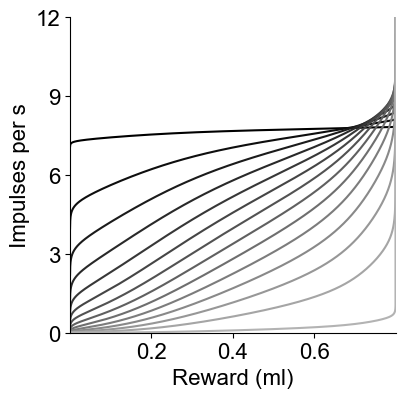

In [37]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_norm.N)

ymax = []
# subsample for only 1 third of ec_unfm.N
for i in range(ec_unfm.N):
    if i%3 == 0:
        plt.plot(ec_norm.x, ec_norm.neurons_[i], color=str(colors[i]))
        ymax.append(ec_norm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.show()
fig.savefig('./figures_rothenhoefer/'+'neuron_norm_pop_subsample.png', bbox_inches="tight")



In [38]:
# N_neurons = 40
# alpha = 0.5
# # others uses res.x
# R_t = 150
# slope_scale = 0.3
# spon_act = 3.92
#
# # cal slopes using spon_act
#
# ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
# ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
#


norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

(10000,)


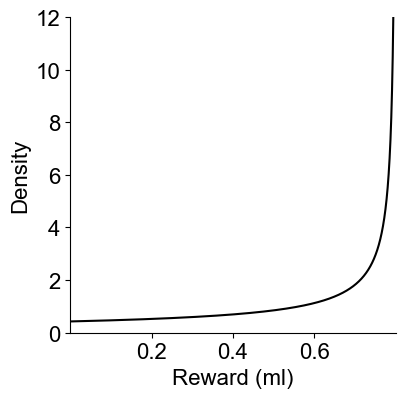

In [39]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

midpoints = []
ymax = []
for i in range(ec_unfm.N):
    ymax.append(ec_unfm.neurons_[i][1499])

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])



# ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.max(), color=str(0.7))

# normalize ec_unfm.d_x so that area under curve is 1
# ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.sum(), color=str(0.7))



ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.sum()/ec_unfm._x_gap, color='k')

plt.ylim([0, 12])
plt.xlim([0, 0.8])
print(ec_norm.d_x.shape) 
plt.show()
fig.savefig('./figures_rothenhoefer/'+'uniform_density_only.png', bbox_inches="tight")


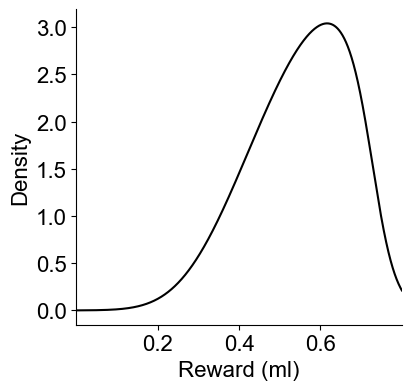

In [40]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)
midpoints=[]
ymax = []
for i in range(ec_norm.N):
    ymax.append(ec_norm.neurons_[i][1499])

    # check if every points in ec_norm.neurons_[i] is smaller than spon_act
    if not np.all(ec_norm.neurons_[i] < spon_act):
        # print(np.argmin(np.abs(ec_norm.neurons_[i] - spon_act)))
        # append midpoints that is ec_unfm.neurons_[i] is closest to spon_act
        midpoints.append(ec_norm.x[np.argmin(np.abs(ec_norm.neurons_[i] - spon_act))])
    else:
        # APPEND nothing to midpoints
        ''


ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Density')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

# plt.ylim([0, 4])
plt.xlim([0, 0.8])


# normalize ec_norm.d_x so that area under curve is 1
ax.plot(ec_norm.x, ec_norm.d_x/ec_norm.d_x.sum()/ec_norm._x_gap, color='k')
plt.show()

fig.savefig('./figures_rothenhoefer/'+'normal_density.png', bbox_inches="tight")

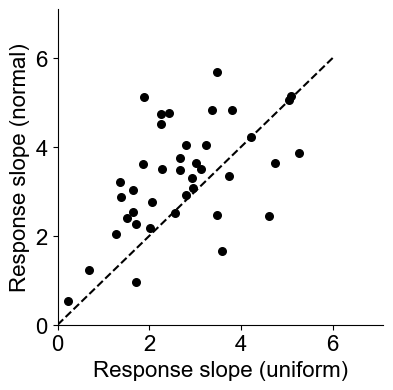

In [41]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig,ax = plt.subplots(1,1)
np.random.seed(15)

# scatter plot of scatter(unfm_res, norm_res) and scatter(data[0], data[1]) and overlay them semi transparent

#ax scatter of unfm_res and norm_res with label='ours'




# plot fitting line for scatter plot
# plt.plot(np.unique(unfm_res), np.poly1d(np.polyfit(unfm_res, norm_res, 1))(np.unique(unfm_res)))
ax.scatter(data[:,0], data[:,1], color='k',label='Measured data' ,s=30)
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0]))) but for data[:,0] and data[:,1]
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0])))

# ax.legend()

ax.set_xlabel('Response slope (uniform)')
ax.set_ylabel('Response slope (normal)')
# overlay y=x dashed line from 0 to 6
ax.plot([0,6], [0,6], 'k--')

ax.set_xlim([0, 7.1])
# set fig's ylim
ax.set_ylim([0, 7.1])



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)


# save the figure the name with alphae
fig.savefig('./figures_rothenhoefer/'+'alpha_true_{}.png'.format(alpha), bbox_inches="tight")

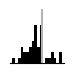

In [42]:
%matplotlib inline

fig,ax = plt.subplots(1,1)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# histogram along y=x
# plt.hist(unfm_res-norm_res, bins=20)
ax.hist(data[:,0]-data[:,1], bins=18, color= 'k')
# plot verical sloid line
ax.axvline(x=0, color=str(0.7), linestyle='-')

ax.set_yticks([])
ax.set_xticks([])

ax.set_ylim([0, 10])

# set y ticks


fig.set_figwidth(.7)
fig.set_figheight(.7)
plt.show()
fig.savefig('./figures_rothenhoefer/'+'histo_ori.png', bbox_inches="tight")



# plt.hist(unfm_res-norm_res, bins=20, alpha=0.5, label='ours')


In [43]:

# N_neurons = 40
# alpha = 0.7
# R_t = 150
# slope_scale = 0.3
# spon_act = 5
#
# # cal slopes using spon_act
#
# ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
# ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)



norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

In [44]:
# wrapper_func_alpha_poisson but with one more argument that number of samples
def wrapper_func_alpha_poisson_samples(params):
    N_neurons = 40
    alpha_norm = params[0]
    alpha_unfm = params[1]
    # others uses res.x
    R_t = 150
    slope_scale_norm = params[2]
    slope_scale_unfm = params[3]
    spon_act = 5
    samples = params[4]

    # if any of params is equal or smaller than 0, return a large number
    if alpha_norm <= 0 or alpha_unfm <= 0 or slope_scale_norm <= 0 or slope_scale_unfm <= 0:
        return 1e5

    # cal slopes using spon_act

    ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
    ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        # poisson sapmling using norm_neg, norm_0, norm_pos but 100 samples
        norm_neg = np.random.poisson(ec_norm.neurons_[i][2500], samples)
        norm_0 = np.random.poisson(ec_norm.neurons_[i][5000], samples)
        norm_pos = np.random.poisson(ec_norm.neurons_[i][7500], samples)

        #take mean of norm_neg, norm_0, norm_pos
        norm_neg = np.mean(norm_neg)
        norm_0 = np.mean(norm_0)
        norm_pos = np.mean(norm_pos)

        norm_neg -= spon_act
        norm_0 -= spon_act
        norm_pos-= spon_act
        norm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [norm_neg, norm_0, norm_pos]))

        unfm_neg = np.random.poisson(ec_unfm.neurons_[i][2500], samples)
        unfm_0 = np.random.poisson(ec_unfm.neurons_[i][5000], samples)
        unfm_pos = np.random.poisson(ec_unfm.neurons_[i][7500], samples)

        #take mean of unfm_neg, unfm_0, unfm_pos
        unfm_neg = np.mean(unfm_neg)
        unfm_0 = np.mean(unfm_0)
        unfm_pos = np.mean(unfm_pos)

        unfm_neg -= spon_act
        unfm_0 -= spon_act
        unfm_pos -= spon_act

        unfm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [unfm_neg, unfm_0, unfm_pos]))
        
    return norm_res, unfm_res


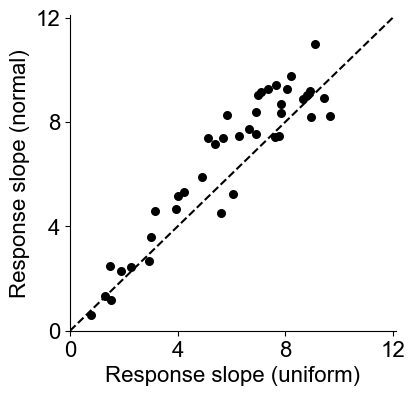

In [48]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig,ax = plt.subplots(1,1)
np.random.seed(794)

norm_res, unfm_res = wrapper_func_alpha_poisson_samples([alpha_norm, alpha_unfm, 
                                                         slope_scale_norm, slope_scale_unfm, 100])

# scatter plot of scatter(unfm_res, norm_res) and scatter(data[0], data[1]) and overlay them semi transparent

#ax scatter of unfm_res and norm_res with label='ours'




ax.scatter(unfm_res, norm_res, color='k', label='Our model', s=30)
# plot fitting line for scatter plot
# plt.plot(np.unique(unfm_res), np.poly1d(np.polyfit(unfm_res, norm_res, 1))(np.unique(unfm_res)))
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0]))) but for data[:,0] and data[:,1]
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0])))

# ax.legend()

ax.set_xlabel('Response slope (uniform)')
ax.set_ylabel('Response slope (normal)')
# overlay y=x dashed line from 0 to 6
ax.plot([0,12], [0,12], 'k--')

ax.set_xlim([0, 12.1])
# set fig's ylim
ax.set_ylim([0, 12.1])



# set x and y axis ticks
ax.set_xticks([0, 4, 8, 12])
ax.set_yticks([0, 4, 8, 12])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

#legend but that is smaller
# ax.legend(fontsize=12)

# save the figure the name with alphae
fig.savefig('./figures_rothenhoefer/alpha_poisson_{}.png'.format(alpha), bbox_inches="tight")
# save in pdf
fig.savefig('./figures_rothenhoefer/alpha_poisson_{}.pdf'.format(alpha), bbox_inches="tight")


In [49]:
plt.close('all')

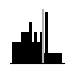

In [50]:
%matplotlib inline

fig,ax = plt.subplots(1,1)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# histogram along y=x
# plt.hist(unfm_res-norm_res, bins=20)
ax.hist(np.array(unfm_res)-np.array(norm_res), bins=18, color= 'k')
# plot verical sloid line
ax.axvline(x=0, color=str(0.7), linestyle='-')

ax.set_yticks([])
ax.set_xticks([])
# set y ticks


fig.set_figwidth(.7)
fig.set_figheight(.7)
fig.savefig('./figures_rothenhoefer/'+'histo_our.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'histo_our.pdf', bbox_inches="tight")



# plt.hist(unfm_res-norm_res, bins=20, alpha=0.5, label='ours')


In [51]:
np.sum((np.array(unfm_res)-np.array(norm_res))<0)

30